In [4]:
#importeer de juiste packages
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import numpy as np
from keras import regularizers
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import yaml
import matplotlib.image as mpimg
from PIL import Image, ImageDraw
import matplotlib.patches as patches
import os
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pydot

In [5]:
yaml_path = './logs/2022-04-21_13-52-16.239715_000351/2022-04-21_13-52-16.yaml'
image_path = './logs/2022-04-21_13-52-16.239715_000351/2022-04-21_13-52-16.284464_rgb.png'

(-0.5, 1943.5, 1199.5, -0.5)

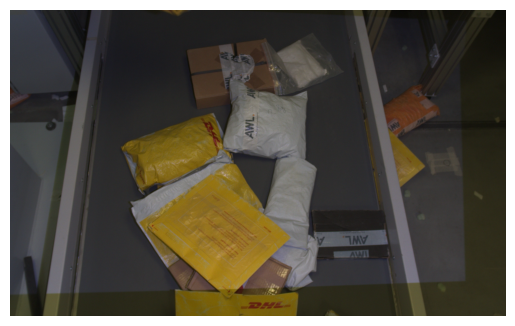

In [6]:
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')

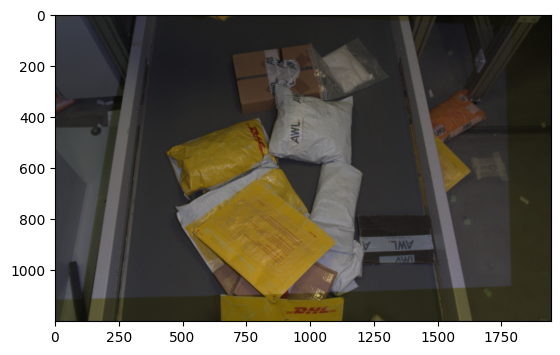

In [7]:
fig, ax = plt.subplots()

# Display the image on the axis
ax.imshow(img)

In [8]:
logs_directory = './logs'
png_file_paths = []
yaml_file_paths = []

for root, dirs, files in os.walk(logs_directory):
    for file in files:
        # Controleer of het bestand een .png-bestand is
        if file.endswith('.png'):
            # Voeg het volledige pad naar het .png-bestand toe aan de lijst
            full_path = os.path.join(root, file)
            png_file_paths.append(full_path)
        if file.endswith('.yaml'):
            full_path = os.path.join(root, file)
            yaml_file_paths.append(full_path)

In [9]:
print(png_file_paths[0])

./logs/2022-04-22_06-28-10.673829_000713/2022-04-22_06-28-10.719677_rgb.png


In [60]:
output_dir = './logs/output_images'
os.makedirs(output_dir, exist_ok=True)

images = []
shape = []
material = []

# Loop door alle PNG- en YAML-bestanden
for image_id in range(len(png_file_paths)):
    img = mpimg.imread(png_file_paths[image_id])  # Laad de afbeelding

    with open(yaml_file_paths[image_id]) as file:
        yaml_data = yaml.safe_load(file)  # Laad de YAML-gegevens

    sorted_detections = None
    for entry in yaml_data:
        if isinstance(entry, dict) and 'sorted_object_detections' in entry:
            sorted_detections = entry['sorted_object_detections']
            break

    if sorted_detections is not None:

        # Loop door de gedetecteerde objecten en teken rechthoeken
        for detection in sorted_detections:
            if not 'descriptors' in detection:
                continue
            foreground_occlusion = detection['descriptors']['occlusion']['foreground']

            # Haal de minimum en maximum coördinaten op voor de box
            if foreground_occlusion > 0.05:
                min_x = detection['box']['minimum'][0]
                min_y = detection['box']['minimum'][1]
                max_x = detection['box']['maximum'][0]
                max_y = detection['box']['maximum'][1]

                shapes = detection['descriptors']['shapes']
                best_shape = max(shapes, key=shapes.get)
                shape.append(best_shape)

                materials = detection['descriptors']['materials']
                best_material = max(materials, key=materials.get)
                material.append(best_material)

                # Teken een rechthoek rond het object
                rect = plt.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y,
                                     linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)

                # Bereken het midden van de rechthoek
                center_x = (min_x + max_x) / 2
                center_y = (min_y + max_y) / 2

                # Print de detection_id in het midden van de rechthoek
                detection_id = detection['detection_id']
                ax.text(center_x, center_y, str(detection_id), color='blue',
                        fontsize=10, ha='center', va='center', fontweight='bold')

                # Snijd de afbeelding uit
                cropped_image = img[min_y:max_y, min_x:max_x]
                resized_image = cv2.resize(cropped_image, (64,64))
                uint8_image = (resized_image * 255).astype(np.uint8)
                images.append(uint8_image)

                # Opslaan van de geknipte afbeelding
                #output_path = os.path.join(output_dir, f'{best_shape}_{best_material}_{detection_id}_{image_id}.png')
                #mpimg.imsave(output_path, normalized_image)

    else:
        print(f"Geen 'sorted_object_detections' gevonden in de YAML-gegevens voor {yaml_file_paths[image_id]}.")

    # Toon de afbeelding met rechthoeken (optioneel)
    plt.show()

Geen 'sorted_object_detections' gevonden in de YAML-gegevens voor ./logs/2022-04-25_07-16-32.486398_005156/2022-04-25_07-16-32.yaml.
Geen 'sorted_object_detections' gevonden in de YAML-gegevens voor ./logs/2022-04-25_07-11-27.636472_005012/2022-04-25_07-11-27.yaml.


In [61]:
len(images), len(shape), len(material)

(2413, 2413, 2413)

In [62]:
images = np.array(images)

In [81]:
data = {
    'shape' : shape,
    'material' : material
}

df = pd.DataFrame(data)

In [82]:
df.head()

,shape,material
0,bag,soft-plastic
1,bag,soft-plastic
2,bag,soft-plastic
3,box,cardboard
4,bag,soft-plastic


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2413 entries, 0 to 2412
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   shape     2413 non-null   object
 1   material  2413 non-null   object
dtypes: object(2)
memory usage: 37.8+ KB


In [84]:
df['shape'].unique()

array(['bag', 'box', 'envelope'], dtype=object)

In [85]:
df['material'].unique()

array(['soft-plastic', 'cardboard', 'paper', 'undefined'], dtype=object)

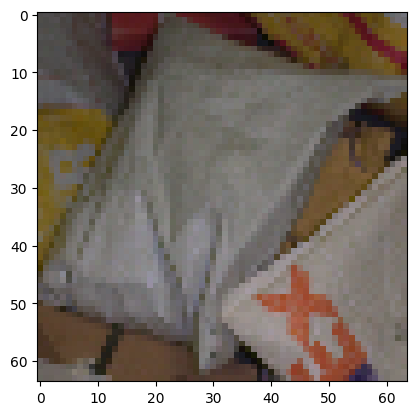

In [86]:
plt.imshow(images[0])  # Display the first image to debug
plt.show()

In [87]:
print(images[0].shape)  # Controleer of de vorm (64, 64, 3) is
print(images[0])  # Controleer de genormaliseerde waarden


(64, 64, 3)
[[[ 77  75  75]
  [ 79  77  78]
  [ 78  76  77]
  ...
  [100 105 108]
  [109 109 112]
  [114 115 123]]

 [[ 78  77  73]
  [ 75  74  72]
  [ 80  77  77]
  ...
  [107  99  94]
  [111 107 114]
  [107 106 110]]

 [[ 75  75  74]
  [ 76  74  72]
  [ 76  75  74]
  ...
  [117  95  54]
  [117  97  49]
  [115 108 115]]

 ...

 [[ 99  96  90]
  [105  99  94]
  [105  99  95]
  ...
  [133 123 118]
  [128 123 118]
  [126 122 109]]

 [[106 101  95]
  [106  99  96]
  [107  99  94]
  ...
  [127 121 114]
  [131 125 116]
  [135 127 121]]

 [[102 101  93]
  [104  97  93]
  [104  98  91]
  ...
  [129 123 115]
  [130 123 116]
  [130 124 119]]]


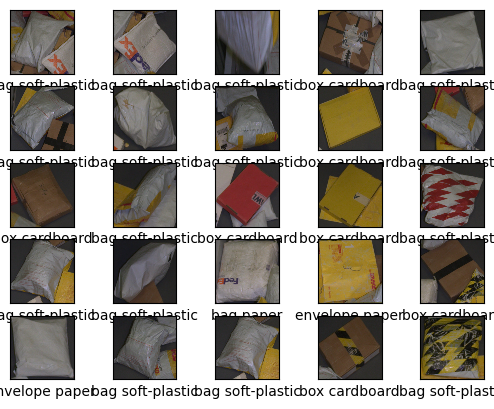

In [88]:
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i])
    plt.xlabel(df['shape'].iloc[i] + " " + df['material'].iloc[i])
plt.show()

In [89]:
images_org = images.copy()

In [90]:
y_shape = df['shape'].values
y_material = df['material'].values

# Convert labels to numerical format using LabelEncoder
label_encoder_shape = LabelEncoder()
label_encoder_material = LabelEncoder()

# Fit and transform the labels
y_shape_encoded = label_encoder_shape.fit_transform(y_shape)
y_material_encoded = label_encoder_material.fit_transform(y_material)

X_train, X_test, y_shape_train, y_shape_test, y_material_train, y_material_test = train_test_split(
    images, y_shape_encoded, y_material_encoded, test_size=0.2, random_state=42)

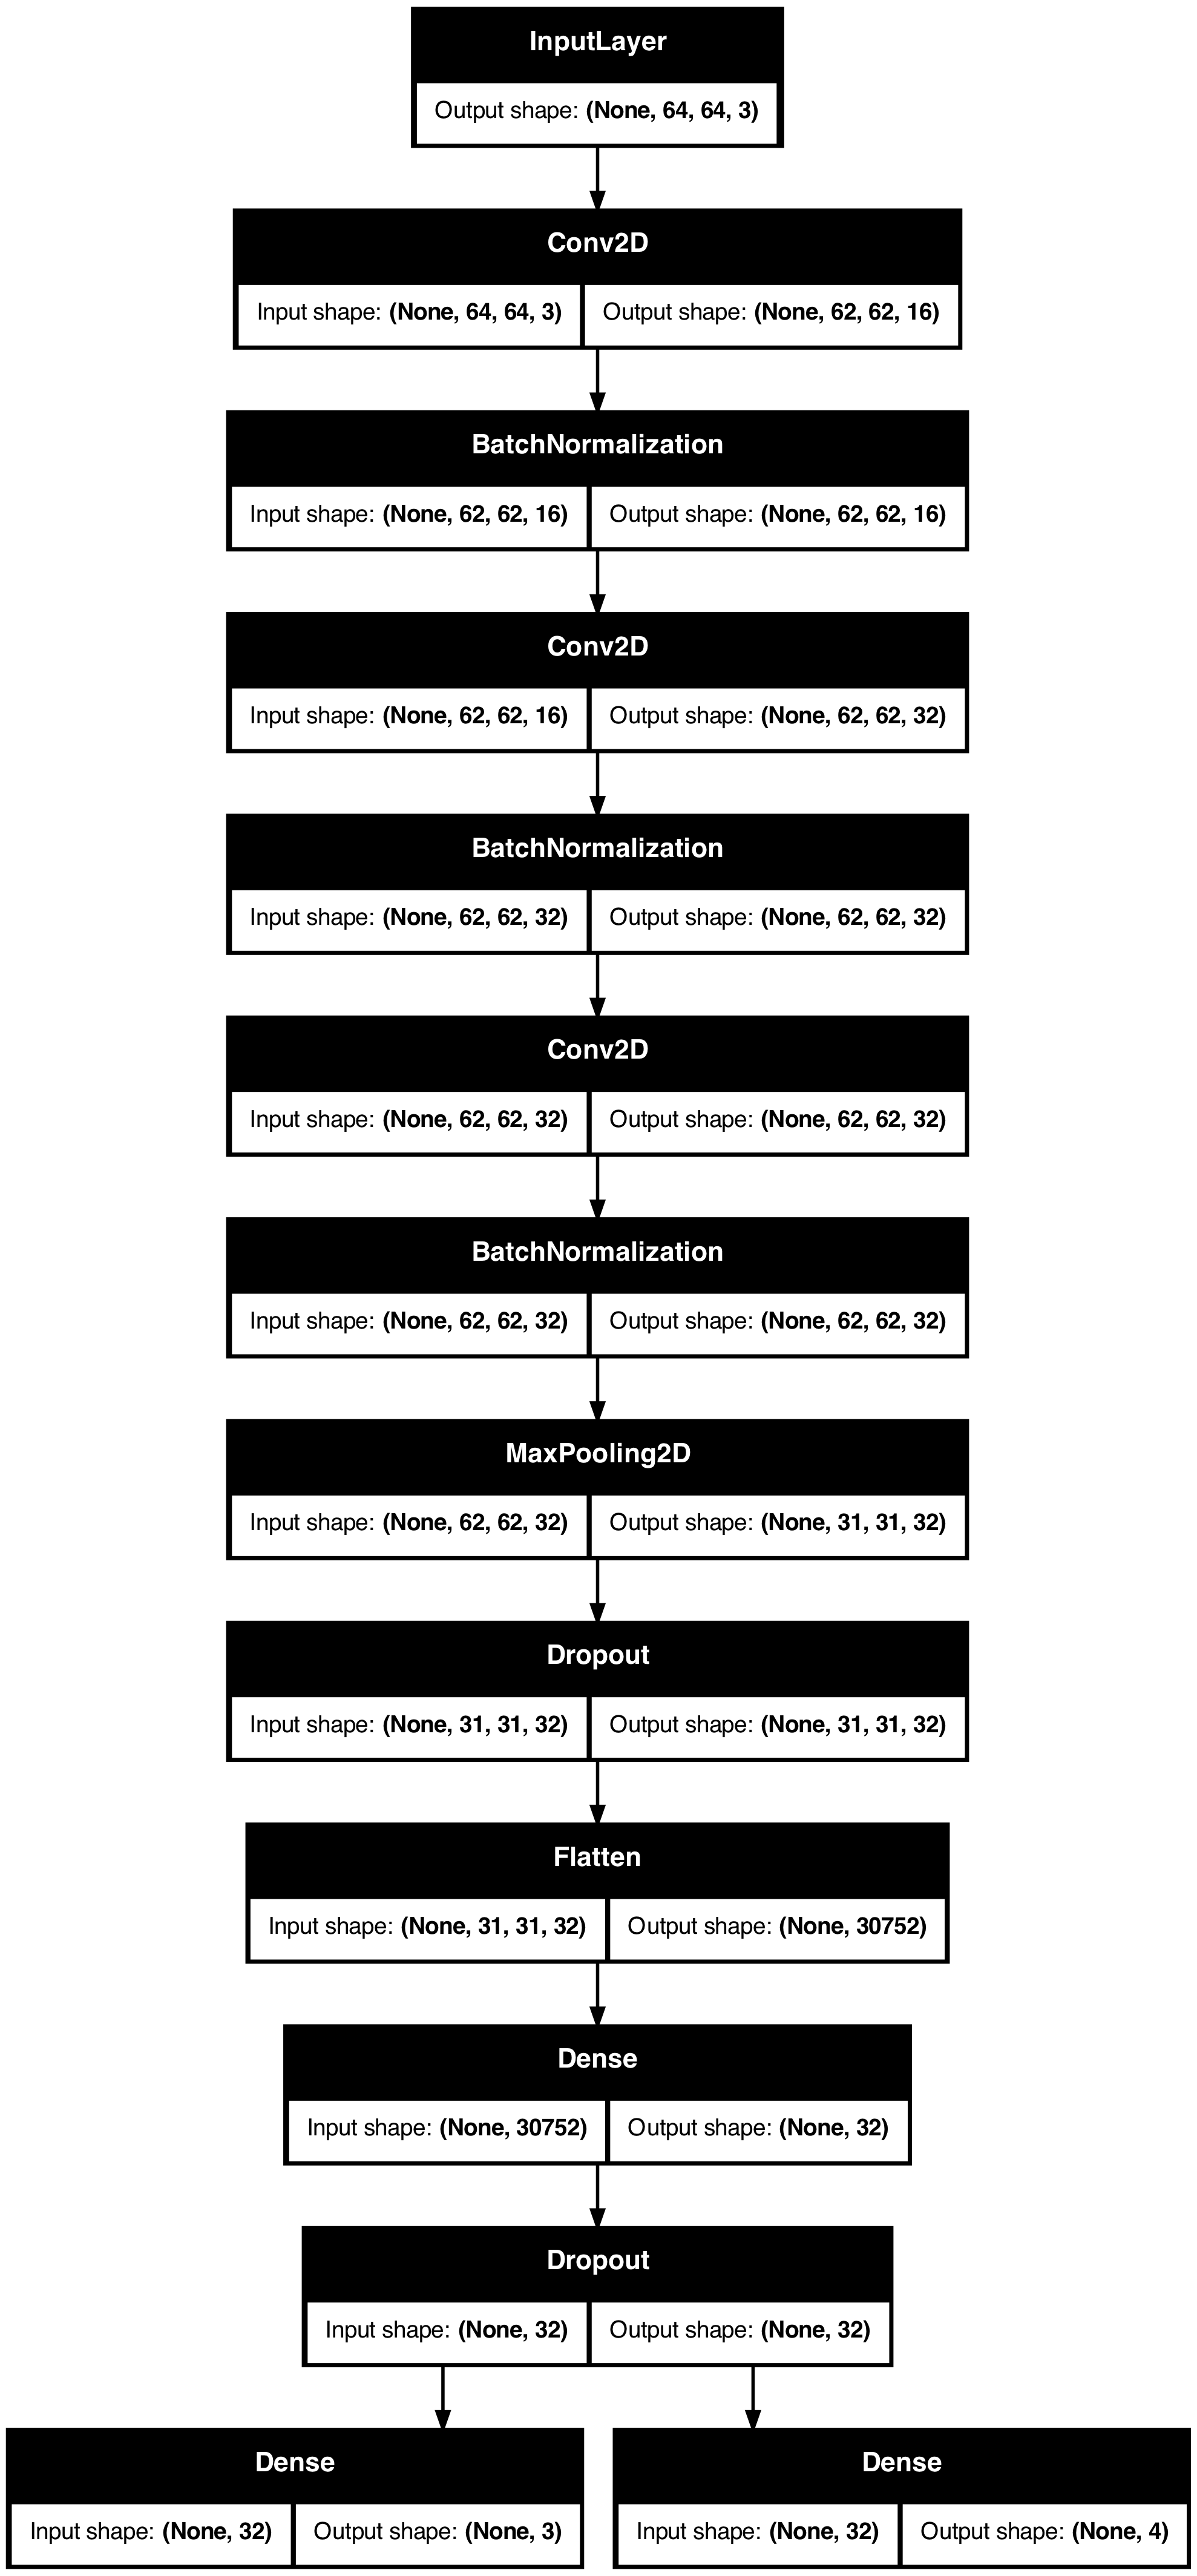

In [91]:
# model = keras.Sequential([
inputs = keras.Input(shape=(64, 64, 3))

x = Conv2D(16, (3, 3), activation='relu')(inputs)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.4)(x)

out_shape = layers.Dense(len(label_encoder_shape.classes_), activation='sigmoid', name='shape_output')(x)
out_material = layers.Dense(len(label_encoder_material.classes_), activation='sigmoid', name='material_output')(x)


# Bouw keras model met functionele API, voor alleen de material
model = keras.Model(inputs=inputs, outputs=[out_shape, out_material])

keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [92]:
#compile
# model.compile(optimizer="ADAM",
#               loss="sparse_categorical_crossentropy",
#               metrics=["accuracy"])

model.compile(
    optimizer="ADAM",
    loss=[keras.losses.SparseCategoricalCrossentropy(), keras.losses.SparseCategoricalCrossentropy()],
    metrics=[
        [
            keras.metrics.CategoricalAccuracy(),
        ],
        [
            keras.metrics.CategoricalAccuracy(),
        ],
    ],
)


In [93]:
print(X_train.shape)
print(y_shape_train.shape, y_material_train.shape)
print(X_test.shape)
print(y_shape_test.shape, y_material_test.shape)

history = model.fit(
    X_train,
    [y_shape_train, y_material_train],
    # batch_size=32,
    epochs=100,
    validation_data=(X_test, [y_shape_test, y_material_test]),
)


(1930, 64, 64, 3)
(1930,) (1930,)
(483, 64, 64, 3)
(483,) (483,)
Epoch 1/1000
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 2.9516 - material_output_categorical_accuracy: 0.1421 - material_output_loss: 1.6560 - shape_output_categorical_accuracy: 0.1134 - shape_output_loss: 1.2954 - val_loss: 2.3920 - val_material_output_categorical_accuracy: 0.2050 - val_material_output_loss: 1.3331 - val_shape_output_categorical_accuracy: 0.1988 - val_shape_output_loss: 1.0605
Epoch 2/1000
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 1.5753 - material_output_categorical_accuracy: 0.2064 - material_output_loss: 0.8736 - shape_output_categorical_accuracy: 0.0790 - shape_output_loss: 0.7017 - val_loss: 2.2103 - val_material_output_categorical_accuracy: 0.2381 - val_material_output_loss: 1.2685 - val_shape_output_categorical_accuracy: 0.1801 - val_shape_output_loss: 1.0050
Epoch 3/1000
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 1.2669 - material_output_categorical_accuracy: 0.2100 - material_out

KeyboardInterrupt: 

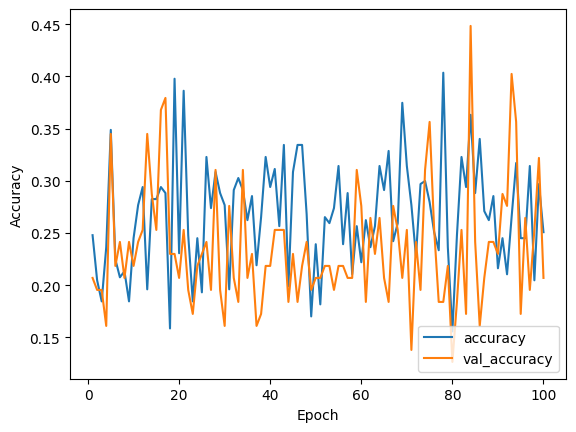

In [57]:
acc=history.history['material_output_categorical_accuracy']
val_acc=history.history['val_material_output_categorical_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [56]:
history.history.keys()

dict_keys(['loss', 'material_output_categorical_accuracy', 'material_output_loss', 'shape_output_categorical_accuracy', 'shape_output_loss', 'val_loss', 'val_material_output_categorical_accuracy', 'val_material_output_loss', 'val_shape_output_categorical_accuracy', 'val_shape_output_loss'])